# Run a SU2 Simulation on a Specific Airfoil and check CL and CD Computation Function
In this tutorial we walk through running and analyzing data from a SU2 simulation for an airfoil.

**_Note:_** The simulations assume/create the following conditions:
1. The airfoil is of length 1. The Reynolds number is sized according to a reference length of 1.  
   And it is not dependent on the actual length of the airfoil.
1. The code places the centroid of the airfoil at the origin.
1. The code rotates the airfoil clockwise by specified angle of attack about the origin.

First some basic imports. The main function to import is `su2_simulation_func` that runs our SU2
simulation.

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from cfd_utils.su2_simulation_func import su2_simulation_func
from airfoil_utils import load_airfoil
from cfd_utils.utils import compute_lift_drag

## Define Simulation Configurations
We need to define some necessary simulation properties.

Note that the mesh fineness can be changed by tuning the `mesh_size_at_airfoil` parameter.

The type of simulation can be chosen to be `EULER` or `RANS`.

Note that the Reynolds number indirectly depends on the Mach number (`Mach_num`).

The simulation can be run at a different angle of attack by specifying `angle_of_attack` (in
degrees) which creates a new mesh for the rotated airfoil (instead of rotating the mesh for the
original airfoil).

The simulation convergence conditions can be set using `max_iterations` and `conv_residual`.

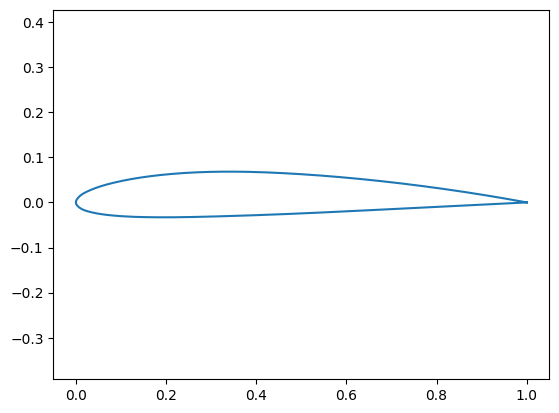

In [2]:
# Get the geometry
airfoil_name = 'naca2410'
X = load_airfoil(airfoil_name)

# Visualize the geometry
plt.plot(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

In [ ]:
# Define simulation properties
Mach_num = 0.25
mesh_factor_at_airfoil = 1.0
mesh_size_at_farfield = 5.0
farfield_factor = 100
fan_count = 20
type_of_simulation = 'rans'
simulation_data_save_dir = Path(f'./dataset/{type_of_simulation}')
max_iterations = 4000
conv_residual = 1e-7
angle_of_attack = 0
template_cfg_file_path = Path(f'./su2_rans_template.cfg')
cfl_adapt = 'YES'
show_errors = False

## Run Simulation
We can now run our simulation using the `su2_simulation_func` function. This saves our data in the
SU2 file formats and also in `.npy` files for easy and fast reading using numpy.

The function returns simulation details which can be investigated to check that the simulation
parameters made sense and whether the simulation converged or not amongst other useful information.

In [4]:
# Run the simulation and save the data
simulation_info = su2_simulation_func(
    airfoil_name = airfoil_name,
    X = X,
    Mach_num = Mach_num,
    mesh_factor_at_airfoil = mesh_factor_at_airfoil,
    mesh_size_at_farfield = mesh_size_at_farfield,
    farfield_factor = farfield_factor,
    fan_count = fan_count,
    type_of_simulation = type_of_simulation,
    simulation_data_save_dir = simulation_data_save_dir,
    max_iterations = max_iterations,
    conv_residual = conv_residual,
    angle_of_attack_deg = angle_of_attack,
    template_cfg_file_path = template_cfg_file_path,
    cfl_adapt = cfl_adapt,
    show_errors = show_errors
)

if not simulation_info['converged']:
    print(f'DID NOT CONVERGE. Airfoil: {airfoil_name:{15}} AoA: {angle_of_attack:2d}')

# Print simulation info
import json
print(json.dumps(simulation_info, indent = 4))

{
    "airfoil_name": "naca2410",
    "AoA": 0,
    "mesh_info": {
        "consecutive_point_min_dist": 2.7451160589026345e-05,
        "consecutive_point_max_dist": 0.005246773331994879,
        "Re": 5823484.750152016,
        "y_H": 9.17866418639192e-06,
        "delta_99": 0.016855708347353334,
        "G": 1.2,
        "N": 36,
        "BL_thickness": 0.032483378604933534,
        "mesh_generation_time": 0.6727938652038574,
        "mesh_details": {
            "num_nodes": 31572,
            "num_elements": 41448,
            "physical_groups": {
                "airfoil_curves": [
                    1,
                    2,
                    3,
                    4,
                    5,
                    6,
                    7,
                    8,
                    9,
                    10,
                    11,
                    12,
                    13,
                    14,
                    15,
                    16,
                    17,
     

We can read the following simulation data files that SU2 produces:
1. `history.csv`
1. `surface_flow.csv`
1. `flow.vtu`

The simulation function automatically reads data from these files and saves the information in
`.npy` format to allow easy and fast reading for downstream tasks.

## Compute CL and CD using Point Data on Surface and Compare with SU2 outputs
We now check that our function to compute CL and CD from the surface pressure distribution matches
the values output by SU2.

In [5]:
# Read history data
history_data = np.load(simulation_data_save_dir / airfoil_name / f'AoA_{str(angle_of_attack)}'
                       / 'history.npy', mmap_mode = 'r')

CL_su2 = history_data['CL'][-1]
CD_su2 = history_data['CD'][-1]

print(f'CL reported by SU2: {CL_su2}')
print(f'CD reported by SU2: {CD_su2}')

CL reported by SU2: 0.2224214637
CD reported by SU2: 0.00862822806


In [6]:
# Read surface flow data
surface_data = np.load(simulation_data_save_dir / airfoil_name / f'AoA_{str(angle_of_attack)}'
                       / 'surface_flow.npy', mmap_mode = 'r')

x_surf = surface_data['x']
y_surf = surface_data['y']
rho = surface_data['Density']
rho_u = surface_data['Momentum_x']
rho_v = surface_data['Momentum_y']
e = surface_data['Energy']

# Compute the velocities in x and y direction
u = rho_u / rho
v = rho_v / rho

# Compute pressure on the surface
gamma = 1.4
p = (gamma - 1) * (e - (1 / 2) * rho * (u * u + v * v))
p_inf = 101325.0

# Compute freestream quantities
R_gas = 287.87
T_inf = 288.15
rho_inf = p_inf / (R_gas * T_inf)
U_inf = Mach_num * np.sqrt(gamma * R_gas * T_inf)
q_inf = (1 / 2) * rho_inf * U_inf * U_inf

# Compute the pressure coefficient
Cp_surf = (p - p_inf) / (q_inf)

X_surf = np.vstack([x_surf, y_surf]).T

In [7]:
CL_func_surf, CD_func_surf = compute_lift_drag(X = X_surf, Cp = Cp_surf)

print(f'CL calculated from function and surface flow: {CL_func_surf}')
print(f'CD calculated from function and surface flow: {CD_func_surf}')

CL calculated from function and surface flow: 0.2223082613229947
CD calculated from function and surface flow: 0.0014701714512254513


In [8]:
# Read volume flow data
flow_data = np.load(simulation_data_save_dir / airfoil_name / f'AoA_{str(angle_of_attack)}'
                    / 'flow.npy', mmap_mode = 'r')

for header in flow_data.dtype.names:
    print(header)

# Access data column-wise taking advantage of lazy loading
x_flow = flow_data['x']
y_flow = flow_data['y']
Cp_flow = flow_data['Pressure_Coefficient']
Cfx_flow = flow_data['Skin_Friction_Coefficient_x']
Cfy_flow = flow_data['Skin_Friction_Coefficient_y']

X_flow = np.vstack([x_flow, y_flow]).T

# Compare point coordinates from the surface and volume data files
print(X_surf[:10, :])
print(X_flow[:10, :])

x
y
Density
Momentum_x
Momentum_y
Energy
Pressure
Temperature
Mach
Pressure_Coefficient
Velocity_x
Velocity_y
Nu_Tilde
Laminar_Viscosity
Skin_Friction_Coefficient_x
Skin_Friction_Coefficient_y
Heat_Flux
Y_Plus
Eddy_Viscosity
[[ 0.49916805 -0.00984866]
 [ 0.49914064 -0.00984363]
 [ 0.49905839 -0.00982854]
 [ 0.49892133 -0.0098034 ]
 [ 0.49872947 -0.00976821]
 [ 0.49848282 -0.00972298]
 [ 0.49818142 -0.00966773]
 [ 0.49782529 -0.00960248]
 [ 0.49741448 -0.00952724]
 [ 0.49694904 -0.00944204]]
[[ 0.49916804 -0.00984866]
 [ 0.49914065 -0.00984363]
 [ 0.4990584  -0.00982854]
 [ 0.49892133 -0.0098034 ]
 [ 0.49872947 -0.00976821]
 [ 0.49848282 -0.00972298]
 [ 0.4981814  -0.00966773]
 [ 0.4978253  -0.00960248]
 [ 0.49741447 -0.00952724]
 [ 0.49694905 -0.00944204]]


In [9]:
# Get surface point indices from the volume flow data
# Point coordinates do not match exactly for the surface and volume data - do closest point search
diff = X_surf[:, None, :] - X_flow[None, :, :]
idx = np.argmin(np.sum(diff * diff, axis = 2), axis = 1)

X_flow_selected = X_flow[idx]
Cp_flow_selected = Cp_flow[idx]
Cfx_flow_selected = Cfx_flow[idx]
Cfy_flow_selected = Cfy_flow[idx]

# Check that the Cp calculated from surface data is equal to that given by SU2 in flow data
print(Cp_flow_selected[:10])
print(Cp_surf[:10])

[0.18802176 0.19853117 0.19713612 0.19600323 0.19443741 0.19278477
 0.19082041 0.18874066 0.1864771  0.18409018]
[0.18478664 0.19529457 0.19389972 0.19276698 0.19120138 0.18954898
 0.1875849  0.18550543 0.18324218 0.18085561]


In [10]:
CL_func_flow, CD_func_flow = compute_lift_drag(X = X_flow_selected, Cp = Cp_flow_selected,
                                               Cfx = Cfx_flow_selected, Cfy = Cfy_flow_selected)

print(f'CL calculated from function: {CL_func_flow}')
print(f'CD calculated from function: {CD_func_flow}')

CL calculated from function: 0.22241666913032532
CD calculated from function: 0.008628306910395622


In [11]:
# Compare the CL and CD values from different sources
print(f'CL reported by SU2: {CL_su2}')
print(f'CD reported by SU2: {CD_su2}')

print(f'CL calculated from function and surface flow: {CL_func_surf}')
print(f'CD calculated from function and surface flow: {CD_func_surf}')

print(f'CL calculated from function and volume flow: {CL_func_flow}')
print(f'CD calculated from function and volume flow: {CD_func_flow}')

CL reported by SU2: 0.2224214637
CD reported by SU2: 0.00862822806
CL calculated from function and surface flow: 0.2223082613229947
CD calculated from function and surface flow: 0.0014701714512254513
CL calculated from function and volume flow: 0.22241666913032532
CD calculated from function and volume flow: 0.008628306910395622
